## Three ceturies of English grain production in Berkshire and Hampshire, England.
### Modeling differences between two groups using Pystan

Ara Winter<br>
2017-06-29

This documents uses a model that compares the means and standard deviations of two groups. This is carried out in the pystan framework. 

In [41]:
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
from IPython.display import Image
import numpy as np
%matplotlib inline

### Example: Three centuries of English grain production
To demostrate this model we will be using the Three centuries of English crop yields, 1211-1491. The full dataset is describe here: http://www.cropyields.ac.uk/login.php . 

We are using a small subset of the total data. The data set contains: wheat gross yield per seed ratio, county, manor, estate, and year. 


#### Reference
Bruce M. S. Campbell (2007), Three centuries of English crops yields, 1211‑1491 [WWW document]. URL http://www.cropyields.ac.uk [accessed on 29/June/2017]

### Where are we?
We are going to look at just two manors in two seperate counties in England. Berkshire and Hampshire and the manors Alresford and Brightwell, respectively. 

<tr>
<td> Berkshire<img src="200px-Berkshire_UK_locator_map_2010.svg.png" title="Berkshire" style="width: 250px;"/> </td>
<td> Hampshire<img src="200px-Hampshire_UK_locator_map_2010.svg.png" alt="Hampshire" style="width: 250px;"/> </td>
</tr>



maps by Unknown (wikimedia), distributed Creative Commons Attribution-Share Alike 3.0 Unported

### Data
First we need to load the .csv with the data in it. Here we are going to use pandas (acts like a R data frame) and from there pull out the data we need.

In [42]:
# Import data
grain_data = pd.read_csv('./three_centuries_of_grain/berkshire_hampshire_grain_1349_1458.txt', sep="\t")
# Here I am telling pd.read_csv that in the folder where my notebook is I have another folder called:
# three_centuries_of_grain. And in that folder I have a tab (\t) seperated comma seperated file. 
# We then ask pandas to read it in and stick it in a data frame called grain_data

In [43]:
grain_data.head(4)

,County,Manor,Estate,start,end,wheat_gross_yield_per_seed_ratio
0,Hampshire,Alresford,Bishop of Winchester,1349,1350,2.89
1,Hampshire,Alresford,Bishop of Winchester,1350,1351,3.09
2,Hampshire,Alresford,Bishop of Winchester,1351,1352,4.25
3,Hampshire,Alresford,Bishop of Winchester,1352,1353,3.17


In [44]:
grain_data.tail(4)

,County,Manor,Estate,start,end,wheat_gross_yield_per_seed_ratio
214,Berkshire,Brightwell,Bishop of Winchester,1454,1455,NaN
215,Berkshire,Brightwell,Bishop of Winchester,1455,1456,NaN
216,Berkshire,Brightwell,Bishop of Winchester,1456,1457,NaN
217,Berkshire,Brightwell,Bishop of Winchester,1457,1458,NaN


In [45]:
grain_data.describe()
# Most of this doesn't matter execept for the wheat gross yield per seed ratio.
# The mean and std can be helpful for setting our priors.

,start,end,wheat_gross_yield_per_seed_ratio
count,218.00000,218.00000,129.000000
mean,1403.00000,1404.00000,4.420853
std,31.53668,31.53668,1.607587
min,1349.00000,1350.00000,0.970000
25%,1376.00000,1377.00000,3.170000
50%,1403.00000,1404.00000,4.150000
75%,1430.00000,1431.00000,5.560000
max,1457.00000,1458.00000,8.800000


In [46]:
# You will notice we have lots of missing data.
grain_data.isnull().sum()

County                               0
Manor                                0
Estate                               0
start                                0
end                                  0
wheat_gross_yield_per_seed_ratio    89
dtype: int64

### Exploratory plots

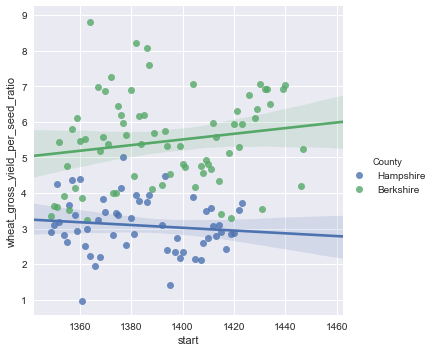

In [47]:
# Here we just want to plot the data over time. 
sns.lmplot("start", "wheat_gross_yield_per_seed_ratio", data=grain_data, hue='County', fit_reg=True)

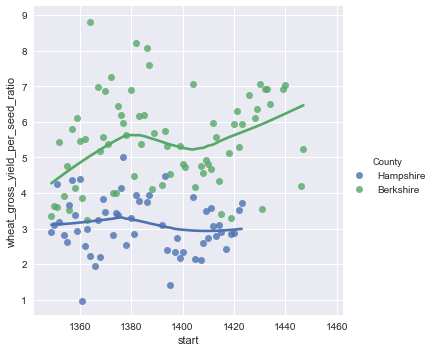

In [48]:
# It's likely that a non-linear fit to the data is better but that's a different question and different model.
sns.lmplot("start", "wheat_gross_yield_per_seed_ratio", data=grain_data, hue='County', lowess=True)

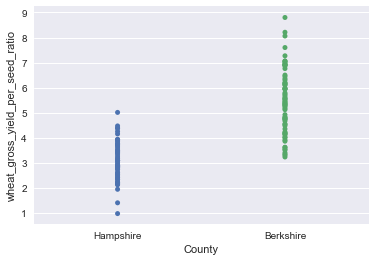

In [49]:
# And here we just look at the bulk difference between Hampsire and Berkshire
sns.stripplot(x="County", y="wheat_gross_yield_per_seed_ratio", data=grain_data);

### Our question
Just by looking at the data we can dream of lots of questions. There are two that I am interested in:<br>
Is the wheat gross yield per seed ratio different between Hampsire and Berkshire from 1349-1457?<br>
When is the wheat gross yield per seed ratio different between Hampsire and Berkshire from 1349-1457?<br>

The second one is arguable more interesting. And ideally we would dig into what things predict the yield from year to year. Is it the previous years yield or spring plantings or something else?

In this notebook we are going to address the first question. 

### Model
We have lots of choices for modeling. Do we only use complete cases? This will reduce the size of the data. Or do we try and model it with NAs. I am not sure of the NA's are missing data or actually zero for wheat gross yield per seed ratio.<br>
First I am going to split my dataframe by County.

In [50]:
# This allows us to only have complete cases. 
matched_grain = grain_data.dropna(axis=0, how='any')

In [51]:
# Just checking to make sure all the NA's are gone.
matched_grain.isnull().sum()

County                              0
Manor                               0
Estate                              0
start                               0
end                                 0
wheat_gross_yield_per_seed_ratio    0
dtype: int64

In [52]:
matched_grain.describe()

,start,end,wheat_gross_yield_per_seed_ratio
count,129.000000,129.000000,129.000000
mean,1389.193798,1390.193798,4.420853
std,25.945278,25.945278,1.607587
min,1349.000000,1350.000000,0.970000
25%,1367.000000,1368.000000,3.170000
50%,1386.000000,1387.000000,4.150000
75%,1411.000000,1412.000000,5.560000
max,1447.000000,1448.000000,8.800000


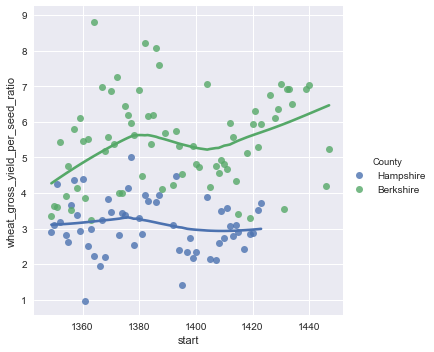

In [53]:
# This doesn't look to much different from our earlier raw plots. So the complete cases data should 
# be good to work with.
sns.lmplot("start", "wheat_gross_yield_per_seed_ratio", data=matched_grain, hue='County', lowess=True)

In [54]:
# We seperate out each county into it's own data frame. 
berkshire = matched_grain.loc[matched_grain['County'] == 'Berkshire']
hampshire = matched_grain.loc[matched_grain['County'] == 'Hampshire']

In [55]:
# Here is the data to model. Note we convert the dataframe column to a python list. 
y1 = berkshire.wheat_gross_yield_per_seed_ratio.tolist()
y2 = hampshire.wheat_gross_yield_per_seed_ratio.tolist()
# Here we just ask what is the length of the data.
n1 = len(y1)
n2 = len(y2)

In [56]:
# Dictionary containing all data to be passed to STAN
compare_groups = {'y1': y1,'y2': y2,'N':[n1,n2]}

In [57]:
# Corrected by Bob Carpenter 
model_string = """
data {
  int N[2];
  vector[N[1]] y1;
  vector[N[2]] y2;
}
parameters {
  vector[2] mu;
  vector<lower=0>[2] sigma;
}
model {
  mu ~ normal(0, 10);
  sigma ~ cauchy(0, 5);
  y1 ~ normal(mu[1], sigma[1]);
  y2 ~ normal(mu[2], sigma[2]);
}
"""

In [58]:
# Compiling and producing posterior samples from the model.
fit_compare_groups = pystan.stan(model_code=model_string, data=compare_groups,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1f0ebaa1784e353e9595dea46e6ad140 NOW.


In [59]:
fit_compare_groups

Inference for Stan model: anon_model_1f0ebaa1784e353e9595dea46e6ad140.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      5.44  3.4e-3   0.15   5.14   5.34   5.44   5.55   5.74   2000    1.0
mu[1]      3.08  2.5e-3   0.11   2.86   3.01   3.08   3.16    3.3   1930    1.0
sigma[0]   1.31  2.4e-3   0.11   1.11   1.23   1.31   1.38   1.54   2000    1.0
sigma[1]    0.8  1.8e-3   0.08   0.66   0.74   0.79   0.85   0.96   1974    1.0
lp__     -70.59    0.04   1.37  -74.0  -71.3  -70.3 -69.57 -68.82   1092    1.0

Samples were drawn using NUTS at Wed Jul  5 12:42:43 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

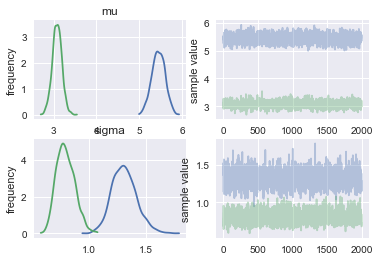

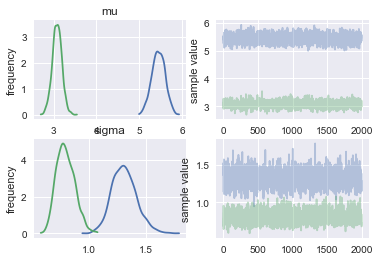

In [60]:
# Plotting the posterior distribution
fit_compare_groups.plot()

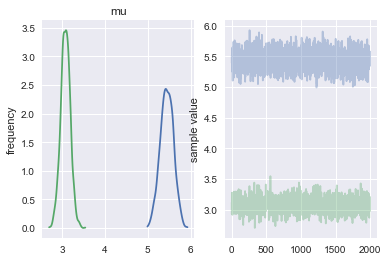

In [61]:
# Instead, show a traceplot for single parameter
fit_compare_groups.plot(['mu'])
plt.show()

In [62]:
# Returns the mean of the local paramter mu
mu = fit_compare_groups.extract(permuted=True)['mu']
np.mean(mu, axis=0)

array([ 5.44328897,  3.08297197])

In [63]:
# Wrangles mu, sigma, and lp__ from the fit.
samples = fit_compare_groups.extract(permuted=True)

In [64]:
# pd.DataFrame(mu)

In [65]:
samples

OrderedDict([('mu', array([[ 5.39315654,  3.11590924],
                     [ 5.51427263,  2.92471952],
                     [ 5.29474491,  3.27395268],
                     ..., 
                     [ 5.36070331,  3.09711642],
                     [ 5.47991208,  3.09878727],
                     [ 5.53821699,  2.99765915]])),
             ('sigma', array([[ 1.36055785,  0.67903394],
                     [ 1.52708895,  0.75655684],
                     [ 1.25973246,  0.82043173],
                     ..., 
                     [ 1.15213013,  0.67458096],
                     [ 1.19646696,  0.72458656],
                     [ 1.38092625,  0.71177656]])),
             ('lp__',
              array([-70.00550767, -71.7138478 , -70.78076945, ..., -71.03384783,
                     -69.33266127, -69.89999525]))])

In [73]:
mu_df = pd.DataFrame(mu)
mu_df.columns = ['mu0', 'mu1']

In [75]:
# Inspect our data frame
mu_df.head(4)

,mu0,mu1
0,5.393157,3.115909
1,5.514273,2.924720
2,5.294745,3.273953
3,5.258699,2.960801


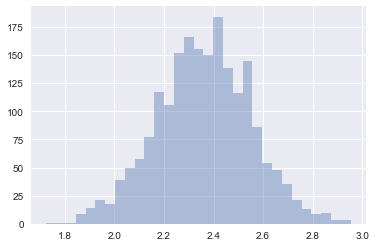

In [77]:
# Plotting distribution of the difference between mu0 and mu1.
sns.distplot((mu_df.mu0-mu_df.mu1), kde=False, rug=False);

In [78]:
# The probability that mu0 is smaller than mu1
l = mu_df.mu0 < mu_df.mu1
sum(l)/len(l)

0.0

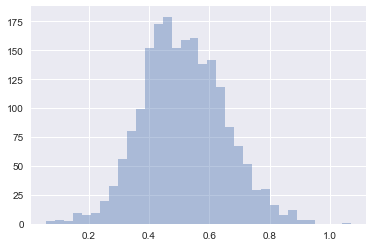

In [121]:
# Plotting distribution of the difference between sigma1 and sigma2.
sns.distplot((params.sigma1 - params.sigma2), kde=False, rug=False);

### Conclusions
This may seem like a lot of work to compare two groups of things. But it unmasks the model that we usually see as a one liner, like the t-test or something similar. <br>
We can also say something about grain production between two counties in England from 1348 - 1448. The mean grain output from Hampshire is greater then the output from Berkshire. However we are left with other questions better left for different models.

### References
Gelman A, Lee D, Guo J. Stan: A probabilistic programming language for Bayesian inference and optimization. Journal of Educational and Behavioral Statistics. 2015 Oct;40(5):530-43.<br>
Breakdown of the Stan model http://m-clark.github.io/workshops/bayesian/03_stan.html <br>
Prior Choice Recommendations https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations <br>


### Better practices
Two things that stand out. We should have heavily annotated priors. So why did I choose mu1 ~ uniform(0, 30) or sigma1 ~ cauchy(0, 20). Once I get a better handle on what does numbers do I'll come back an do an annotated prior entry.

In the data section of our Stan model we really should have bounds on our data that serves as checks. 
So <i>int n1</i> becomes <i>int&lt;lower=1> n1</i>. This sets a boundary that we expect at least one sample.

### Future work
Seaborn handled the linear models for us. So the next project has three parts:<br>
Simple linear model with time predicting grain production<br>
Simple non-linear model fitting of time predicting grain production<br>
Can we write a model that let's us know if previous years harvest influcence the next year<br>